**Download the XGBoost model trained on Indian Face Name dataset**

In [17]:
!git clone https://github.com/Kashyap-Nirmal/Face_Name_Prediction

fatal: destination path 'Face_Name_Prediction' already exists and is not an empty directory.


**Importing necessary libraries**

In [18]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import img_to_array

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import keras
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import MaxPooling2D
from keras.layers import Flatten
import math
import xgboost as xgb

**Feature extraction using Spatial Pyramid Pooling**

In [19]:
# # example of tending the vgg16 model

# load model without classifier layers
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(64, 64, 3))

win1 = math.ceil(16/1)
str1 = math.floor(16/1)

win2 = math.ceil(16/2)
str2 = math.floor(16/2)

win3 = math.ceil(16/4)
str3 = math.floor(16/4)

l1 = keras.layers.MaxPooling2D(pool_size=(win1), strides=str1, padding="valid")(base_model.layers[-10].output)
l2 = keras.layers.MaxPooling2D(pool_size=(win2), strides=str2, padding="valid")(base_model.layers[-10].output)
l3 = keras.layers.MaxPooling2D(pool_size=(win3), strides=str3, padding="valid")(base_model.layers[-10].output)

flat1 = Flatten()(l1)
flat2 = Flatten()(l2)
flat3 = Flatten()(l3)

# # define new model

for layer in base_model.layers:
    layer.trainable = False

model = Model(inputs=base_model.inputs, outputs=[flat1, flat2, flat3])

**Loading the saved XGBoost model**

In [20]:
xgb_cl1 = xgb.XGBClassifier()
booster = xgb.Booster()
booster.load_model("/content/Face_Name_Prediction/Load saved Indian XGBoost Model/Model_XGB_Indian.json")
xgb_cl1._Booster = booster;
xgb_cl1._le = LabelEncoder().fit(["Krishna", "Pranav", "Priya", "Rahul", "Sonal"])

**Please insert the Test image path here**

In [21]:
test_file = 'IMAGE_PATH_HERE'

**Preprocessing the image suited for XGBoost**

In [22]:
# Read the image to detect faces in
img = cv2.imread(test_file)
img = cv2.resize(img, (256, 256))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect Faces
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
face_coordinates = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,          
        minSize=(30, 30)
    )   

img_crop = []
test_file1 = []

for (x, y, w, h) in face_coordinates:
    img_crop.append(img[y:y + h, x:x + w])

for counter, cropped in enumerate(img_crop):
    name = test_file.split('.')
    output_filename = name[0]+"_Crop_"+ str(counter) + ".jpg"    
    test_file1.append(output_filename)
    cv2.resize(cropped,(256,256))
    cv2.imwrite(output_filename, cropped)
    cv2.waitKey(0)    

**Predicting the Test image**

In [23]:
list_name = []

cnt = 1
for i in test_file1 :  
        test_file_X = []
        try:
            image = cv2.imread(i)
            image = cv2.resize(image, (64, 64))
            image = img_to_array(image)
            test_file_X.append(image)
            test_file_X = np.array(test_file_X, dtype="float")/255.0
            img_test = model.predict(test_file_X)
            img_test = np.hstack([img_test[0], img_test[1], img_test[2]])        
            list_name.append(xgb_cl1.predict(img_test)[0])            
            cnt += 1

            #Generating pseudo random number to show the random guess vs Output of the model
            #random.seed(random.randint(0,1000))            
            #n = random.randint(0,4)
            label = {"Krishna":0, "Pranav":1, "Priya":2, "Rahul":3, "Sonal": 4}
            key_list = list(label.keys())
            #print("\nRandom guess is : "+key_list[n])
            
        except Exception as e:
            print(e)

In [24]:
def Name_Association():
    # Choose an image to detect faces in
    img = cv2.imread(test_file)
    img = cv2.resize(img, (256, 256))
    name = test_file.split('.')
    output_filename = name[0]+"_Resized.jpg"    
    img = cv2.imwrite(output_filename, img)

    img = cv2.imread(test_file)
    img = cv2.resize(img, (256, 256))

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect Faces
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    face_coordinates = faceCascade.detectMultiScale(
            gray,
            #scaleFactor=1.3,          
            minSize=(30, 30)
        )   

    # fontScale
    fontScale = 0.5
    
    # Font Color in BGR
    color = (255, 0, 0)
    
    # Line thickness in px
    thickness = 2

    cnt = 0

    for (x, y, w, h) in face_coordinates:    
        name = list_name[cnt]
        cnt += 1
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        font = cv2.FONT_HERSHEY_COMPLEX
        fontScale = (x+y)/100
        fontScale = 1
        if(fontScale>1):
            fontScale = 0.95    
        image = cv2.putText(img, name, (x+2,y), font, 
                    fontScale, color, thickness, cv2.LINE_AA)
        
    name = test_file.split('.')
    output_filename = name[0]+"_Name_Association_"+ str(counter) + ".jpg"    

    status = cv2.imwrite(output_filename, img)
    mpshow = mpimg.imread(output_filename)
    plt.imshow(mpshow)
    print("\nTotal number of faces detected : "+ str(len(img_crop))+"\n\nOutput image with names associated is as below\n")
    plt.show()
                
    if(len(test_file1) == 0) :
        print("Sorry. No face detected. Please insert other image.")
        
    else:
        cnt = 0
        print("\nCropped faces from the input image are as below.")
        for i in test_file1 :  
            test_file_X = []
            try:
                image = cv2.imread(i)
                image = cv2.resize(image, (64, 64))
                image = img_to_array(image)
                test_file_X.append(image)
                test_file_X = np.array(test_file_X, dtype="float")/255.0
                img_test = model.predict(test_file_X)
                img_test = np.hstack([img_test[0], img_test[1], img_test[2]])        
                mpshow = mpimg.imread(i)
                plt.imshow(mpshow)            
                print("\nFace "+ str(cnt+1)+" : "+list_name[cnt]+"\n")
                plt.show()
                cnt += 1
            
            except Exception as e:
                print(e)   


Total number of faces detected : 1

Output image with names associated is as below



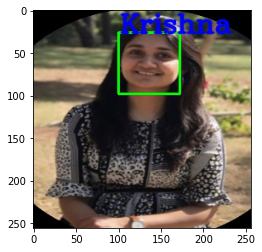


Cropped faces from the input image are as below.

Face 1 : Krishna



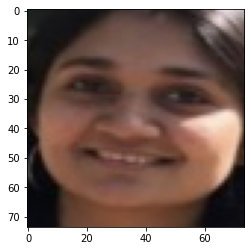

In [25]:
if(len(list_name) != 0):
    Name_Association()
else :
    print("Sorry. No face detected. Please insert other image.")